In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import acf, pacf, ccf, graphics, adfuller, coint
from sklearn.metrics import mean_squared_error as mse
import itertools

import warnings
warnings.filterwarnings("ignore")

# Indonesia Oil Consumption
---

## Load Data

In [2]:
# load dataset
df = pd.read_csv('oil_consumption.csv')
# Display dataset
df.head()

,year,gdp,oil_energy_use
0,1960,3.010000e+11,250.00
1,1961,3.010000e+11,252.57
2,1962,3.010000e+11,259.76
3,1963,3.010000e+11,265.47
4,1964,3.010000e+11,267.09


In [4]:
# Convert the "year", columns to datetime type
df["date"] = pd.to_datetime(df["year"], format='%Y')

# Use the "date" column as the index
df.set_index("date", inplace=True)

# Drop the "Year", "Month", and "Day" columns from the dataframe
df = df.drop('year', axis=1)

# Display dataset
df.head()

,gdp,oil_energy_use
date,,
1960-01-01,3.010000e+11,250.00
1961-01-01,3.010000e+11,252.57
1962-01-01,3.010000e+11,259.76
1963-01-01,3.010000e+11,265.47
1964-01-01,3.010000e+11,267.09


In [5]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1960-01-01 to 2020-01-01
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gdp             61 non-null     float64
 1   oil_energy_use  61 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


In [6]:
# Check for missing values
print(df.isnull().sum())

gdp               0
oil_energy_use    0
dtype: int64


## Time Plot

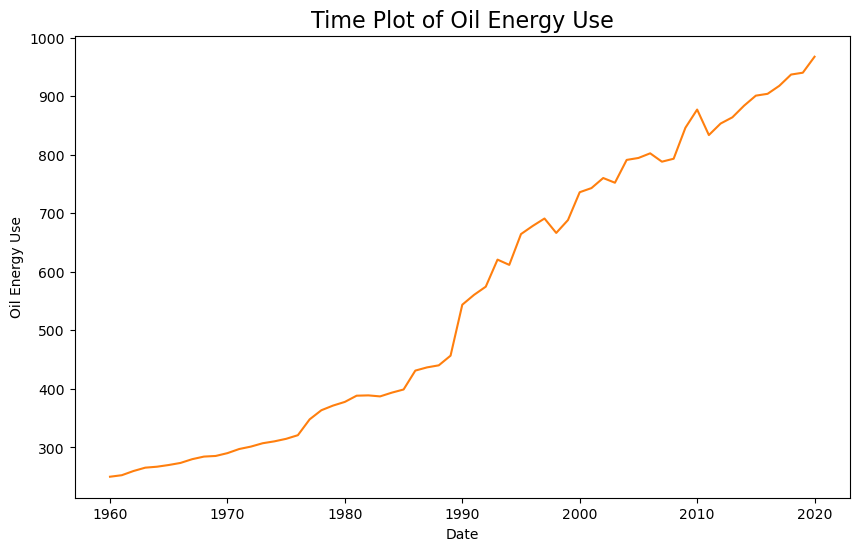

In [7]:
# Create a copy of the 'oil_energy_use' column in the DataFrame
oil = df['oil_energy_use'].copy()

# Plot for Oil Energy Use
plt.figure(figsize=(10, 6))
plt.plot(oil.index, oil, color='tab:orange')
plt.title('Time Plot of Oil Energy Use', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Oil Energy Use')
plt.show()

## Forecasting Model

### Forecasting using Naive

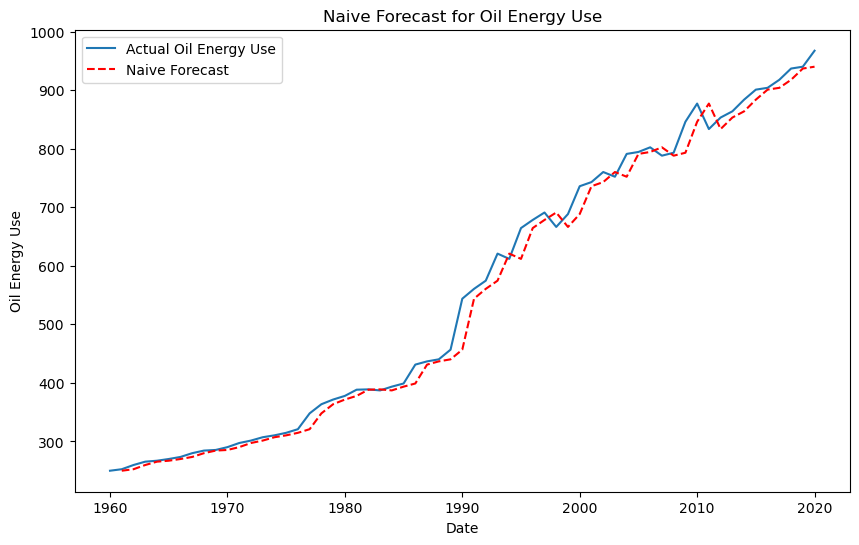

In [8]:
# Function for Naive Forecast on differenced data
def naive_forecast(series):
    forecast = series.shift(1)  # Using the last differenced value as the next forecast
    return forecast

# Applying the naive forecast method to the differenced oil data
oil_naive_forecast = naive_forecast(oil)

# Plotting the results of the naive forecast on differenced data
plt.figure(figsize=(10, 6))
plt.plot(oil.index, oil, label='Actual Oil Energy Use')
plt.plot(oil_naive_forecast.index, oil_naive_forecast, label='Naive Forecast',
         linestyle='dashed', color='red')
plt.title('Naive Forecast for Oil Energy Use')
plt.xlabel('Date')
plt.ylabel('Oil Energy Use')
plt.legend()
plt.show()

In [9]:
# Calculate RMSE for naive
rmse_naive = np.sqrt(mse(oil.fillna(0), oil_naive_forecast.fillna(0)))
print(f'RMSE for Naive Forecast: {rmse_naive}')

RMSE for Naive Forecast: 38.9683230119113


The Root Mean Squared Error (RMSE) of the Naive Forecast will be used as the baseline.

### ACF and PACF

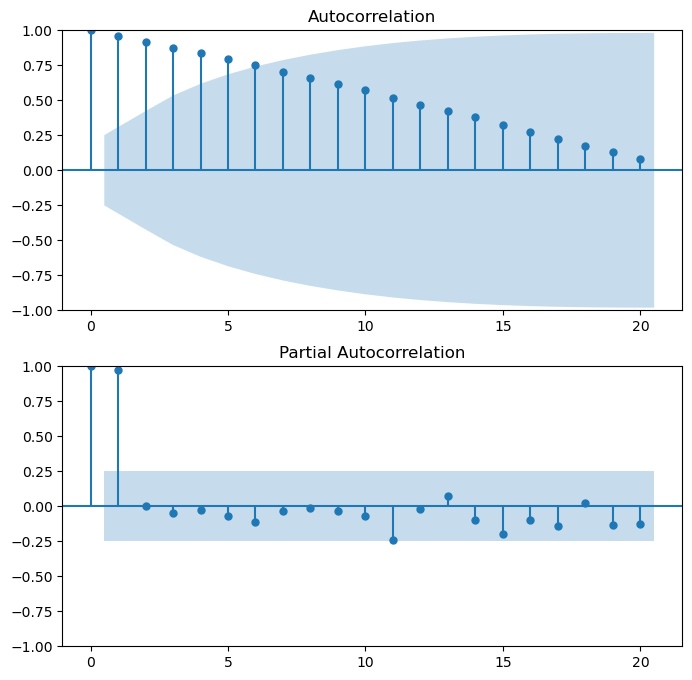

In [10]:
# Create a figure
fig = plt.figure(figsize=(8, 8))

# Add a subplot for the autocorrelation plot
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(oil, lags=20, ax=ax1)

# Add a subplot for the partial autocorrelation plot
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(oil, lags=20, ax=ax2)

# Display the plot
plt.show()

- ACF decreases slowly. Implies evolving patterns or trends.
- ACF shows repeated seasonal patter indicating the seasonal pattern.
- Large, positive value of of autocorrelation are commonly observed in non-stationary data.

### Differencing

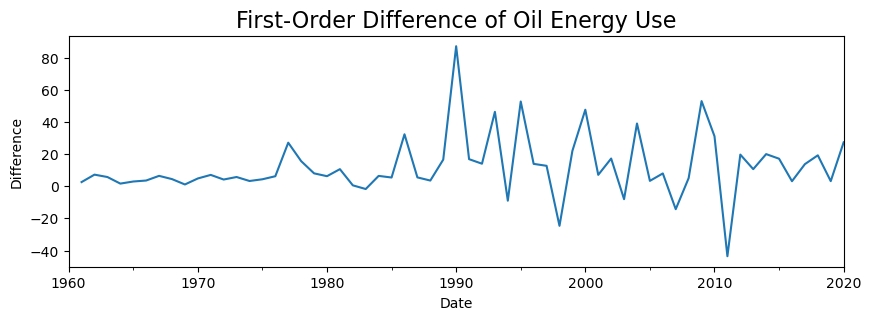

In [11]:
# Calculate the first-order difference of the 'oil_energy_use' time series
oil_diff = oil.diff()

# Plot the differenced time series
oil_diff.plot(figsize=(10, 3))
plt.title('First-Order Difference of Oil Energy Use', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

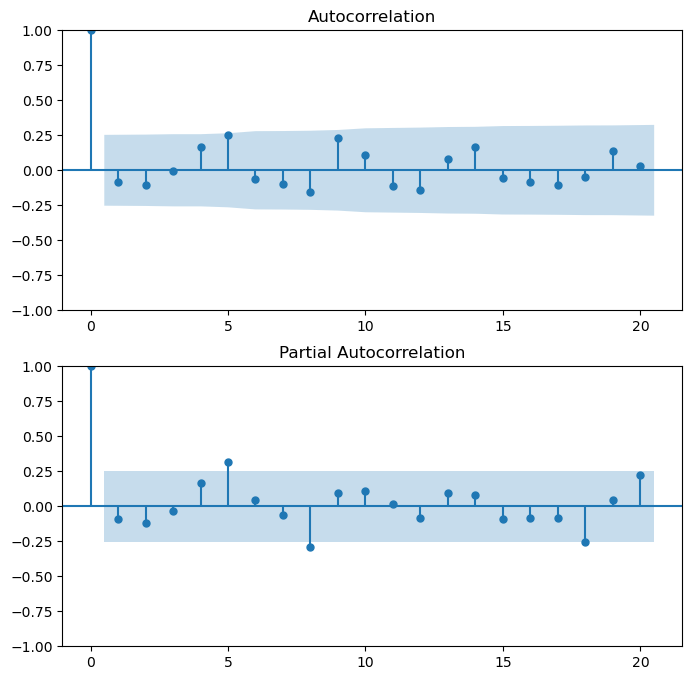

In [12]:
# Create a figure
fig = plt.figure(figsize=(8, 8))

# Add a subplot for the autocorrelation plot after differencing
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(oil_diff.dropna(), lags=20, ax=ax1)

# Add a subplot for the partial autocorrelation plot after differencing
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(oil_diff.dropna(), lags=20, ax=ax2)

# Display the plot
plt.show()

### Forecasting using ARIMA

In [13]:
oil_arima_model = ARIMA(oil, order=(1, 1, 0)).fit()

print(oil_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:         oil_energy_use   No. Observations:                   61
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -270.257
Date:                Sun, 07 Jan 2024   AIC                            544.514
Time:                        21:55:02   BIC                            548.703
Sample:                    01-01-1960   HQIC                           546.152
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.150      1.450      0.147      -0.077       0.512
sigma2       478.1077     55.477      8.618      0.000     369.375     586.840
Ljung-Box (L1) (Q):                   4.28   Jarque-

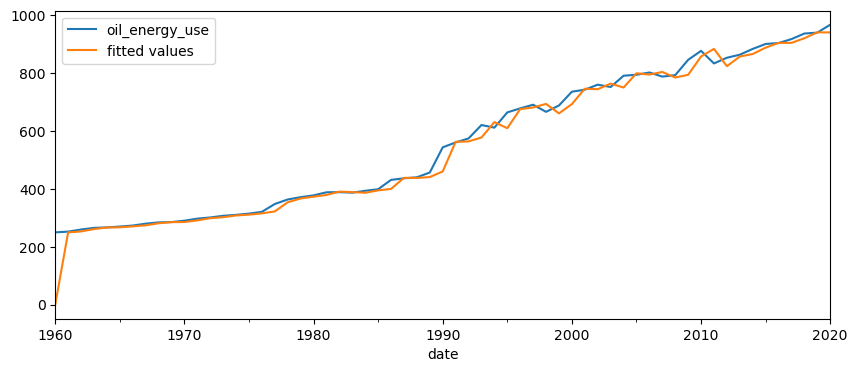

In [14]:
oil.plot(figsize = (10,4), legend = True)
oil_arima_model.fittedvalues.plot(figsize = (10,4), label = "fitted values", legend = True)
plt.show()

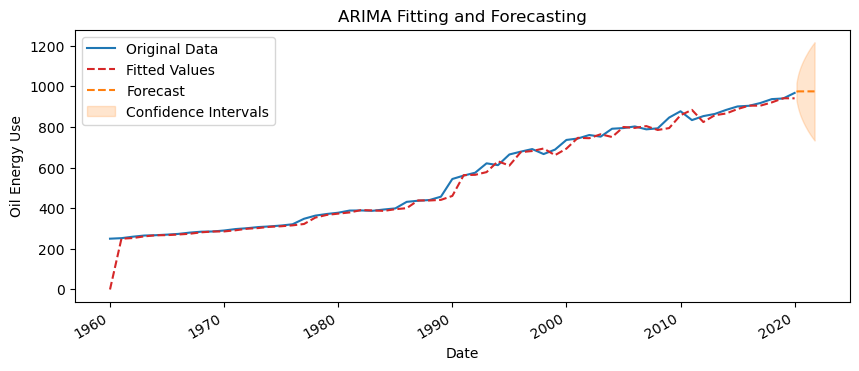

In [15]:
# Forecasting steps
forecast_steps = 20

# Get forecast results
forecast_results = oil_arima_model.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plotting the original series
plt.figure(figsize=(10, 4))
plt.plot(oil.index, oil, label='Original Data', color='tab:blue')

# Plotting the fitted values
oil_arima_model.fittedvalues.plot(label='Fitted Values',
                                  linestyle='dashed', color='tab:red')

# Plotting the forecast
forecast_index = pd.date_range(start=oil.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_index, forecast_values, label='Forecast',
         linestyle='dashed', color='tab:orange')

# Plotting confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='tab:orange', alpha=0.2, label='Confidence Intervals')

plt.title('ARIMA Fitting and Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Energy Use')
plt.legend()
plt.show()

In [16]:
# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mse(oil, oil_arima_model.fittedvalues))
print(f'RMSE for ARIMA: {rmse_arima}')

RMSE for ARIMA: 38.663728016644775


#### Best Model ARIMA

In [17]:
# Initialize p, d, and q parameters
p = d = q = range(0, 3)

# Generate all combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Initialize variable to store AIC values
aic_values = []

# Loop to find the best model
for param in pdq:
    try:
        # Build and train the ARIMA model
        arima_model = ARIMA(oil, order=param).fit()
        
        # Calculate AIC value
        aic = arima_model.aic
        
        # Store AIC value
        aic_values.append((param, aic))
    except:
        continue

# Select the model with the lowest AIC value
best_model_params, best_aic = min(aic_values, key=lambda x: x[1])

# Build and train the best ARIMA model
best_arima_model = ARIMA(oil, order=best_model_params).fit()

# Display the summary of the best model
print(best_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:         oil_energy_use   No. Observations:                   61
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -259.716
Date:                Sun, 07 Jan 2024   AIC                            523.432
Time:                        21:55:06   BIC                            527.587
Sample:                    01-01-1960   HQIC                           525.054
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9505      0.048    -19.777      0.000      -1.045      -0.856
sigma2       374.8524     37.865      9.900      0.000     300.639     449.066
Ljung-Box (L1) (Q):                   1.00   Jarque-

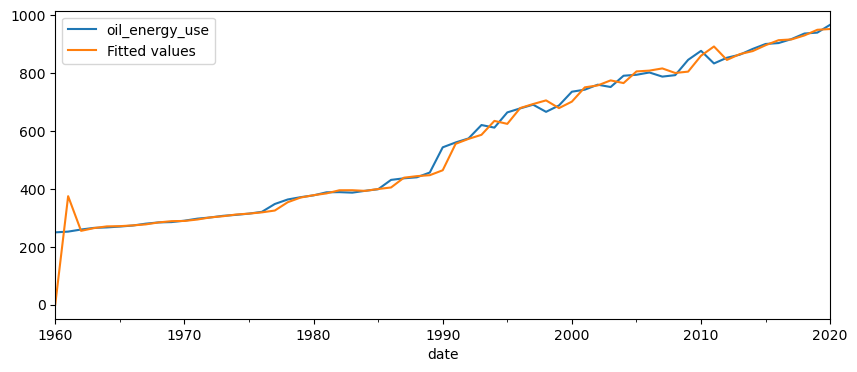

In [18]:
# Plot the original data and the fitted values of the best model
oil.plot(figsize=(10, 4), legend=True)
best_arima_model.fittedvalues.plot(figsize=(10, 4), label="Fitted values", legend=True)
plt.show()

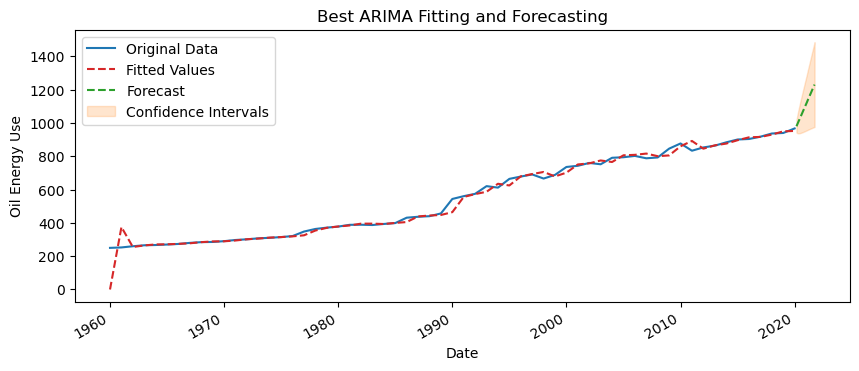

In [19]:
# Forecasting steps
forecast_steps = 20

# Get forecast results
forecast_results = best_arima_model.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plotting the original series
plt.figure(figsize=(10, 4))
plt.plot(oil.index, oil, label='Original Data', color='tab:blue')

# Plotting the fitted values
best_arima_model.fittedvalues.plot(label='Fitted Values',
                                   linestyle='dashed', color='tab:red')

# Plotting the forecast
forecast_index = pd.date_range(start=oil.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_index, forecast_values, label='Forecast', linestyle='dashed', color='tab:green')

# Plotting confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='tab:orange', alpha=0.2, label='Confidence Intervals')

plt.title('Best ARIMA Fitting and Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Energy Use')
plt.legend()
plt.show()

In [20]:
# Calculate and display RMSE for the best model
rmse_best_arima = np.sqrt(mse(oil, best_arima_model.fittedvalues))
print(f'RMSE for Best ARIMA Model: {rmse_best_arima}')

RMSE for Best ARIMA Model: 40.427711898381226


- ARIMA performs better: The ARIMA model demonstrates better forecasting accuracy with an RMSE of 38.66, outperforming the Best ARIMA Model with an RMSE of 40.43.

- Comparable precision: Despite the difference, both models exhibit relatively close RMSE values, suggesting a similar level of overall forecasting precision.

### Forecasting using VAR

#### Time Plot for GDP and Oil Energy Use

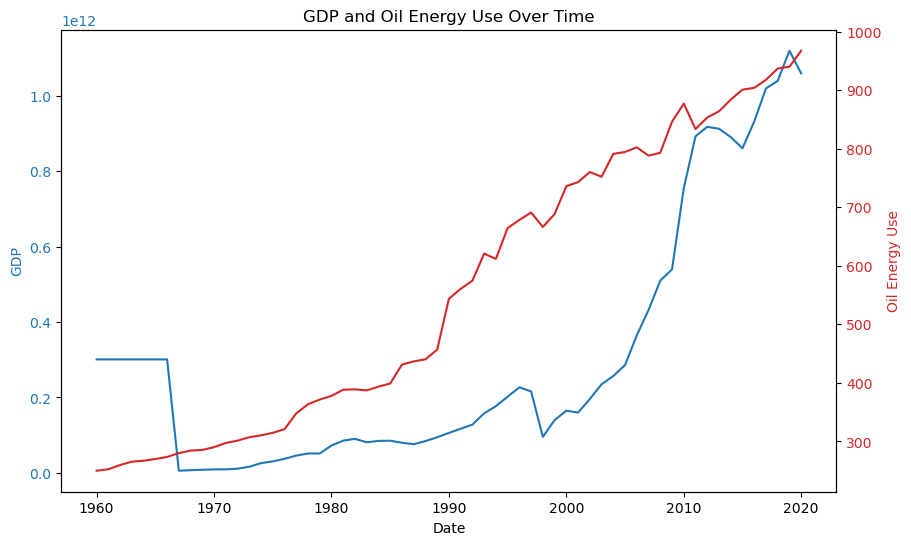

In [21]:
con = df.copy()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for GDP (left axis)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP', color=color)
ax1.plot(con.index, con['gdp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot for Oil Energy Use (right axis)
color = 'tab:red'
ax2.set_ylabel('Oil Energy Use', color=color)
ax2.plot(con.index, con['oil_energy_use'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Display the plot
plt.title('GDP and Oil Energy Use Over Time')
plt.show()

#### ADF Test for GDP and Oil Energy Use

In [22]:
# Creat function for adf test and plot
def adf_test_and_plot(series, name):
    result = adfuller(series)
    print(f'ADF Statistic ({name}): {result[0]}')
    print(f'p-value ({name}): {result[1]}')
    print(f'Critical Values ({name}):')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

In [23]:
# ADF test and plot for GDP
adf_test_and_plot(con['gdp'], 'GDP')

ADF Statistic (GDP): 0.5894830735991663
p-value (GDP): 0.9873535159167555
Critical Values (GDP):
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


In [24]:
# ADF test and plot for Oil Energy Use
adf_test_and_plot(con['oil_energy_use'], 'Oil Energy Use')

ADF Statistic (Oil Energy Use): 0.761593276763978
p-value (Oil Energy Use): 0.9909902229866775
Critical Values (Oil Energy Use):
	1%: -3.5443688564814813
	5%: -2.9110731481481484
	10%: -2.5931902777777776


In [25]:
# Differencing for GDP and Oil Energy Use
con['diff_gdp'] = con['gdp'].diff()

con['diff_oil_energy_use'] = con['oil_energy_use'].diff()

con = con.dropna()

In [26]:
# ADF test and plot after differencing for GDP
adf_test_and_plot(con['diff_gdp'], 'Diff GDP')

ADF Statistic (Diff GDP): -5.8337582177845135
p-value (Diff GDP): 3.9199020055649524e-07
Critical Values (Diff GDP):
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


In [27]:
# ADF test and plot after differencing for Oil Energy Use
adf_test_and_plot(con['diff_oil_energy_use'], 'Diff Oil Energy Use')

ADF Statistic (Diff Oil Energy Use): -8.20663441691751
p-value (Diff Oil Energy Use): 6.996104520011827e-13
Critical Values (Diff Oil Energy Use):
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


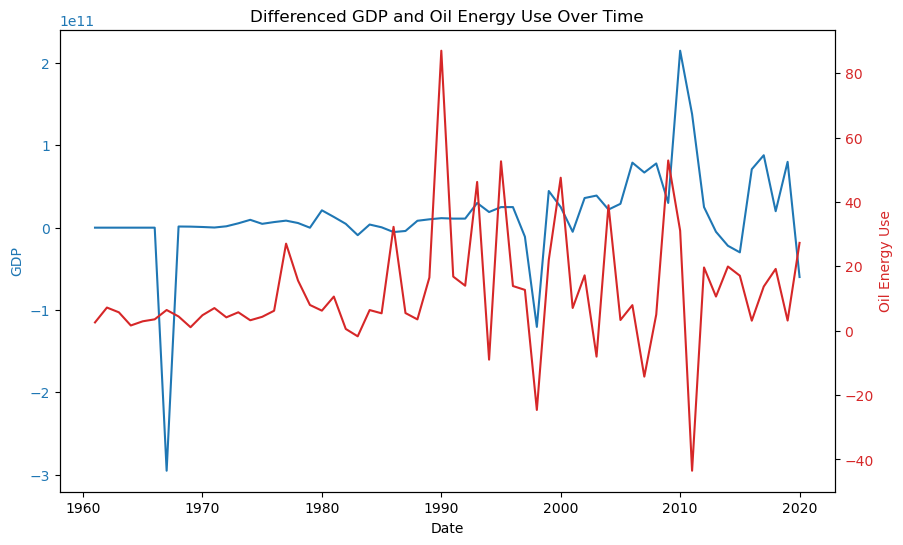

In [28]:
# Membuat gambar dan sumbu pertama
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot untuk GDP (sumbu kiri)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP', color=color)
ax1.plot(con.index, con['diff_gdp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Membuat sumbu kedua yang berbagi sumbu x
ax2 = ax1.twinx()

# Plot untuk Oil Energy Use (sumbu kanan)
color = 'tab:red'
ax2.set_ylabel('Oil Energy Use', color=color)
ax2.plot(con.index, con['diff_oil_energy_use'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Menampilkan plot
plt.title('Differenced GDP and Oil Energy Use Over Time')
plt.show()

#### Engle-Granger Test for Cointegration

In [29]:
# Test for cointegration (GDP as the dependent variable)
coint_t, p_val, _ = coint(con['diff_gdp'],
                          con['diff_oil_energy_use'],
                          maxlag = 20)
print(f'P-value for cointegration test (GDP as dependent): {p_val}')

P-value for cointegration test (GDP as dependent): 0.5389276989606049


In [30]:
# Test for cointegration (Oil Energy Use as the dependent variable)
coint_t, p_val, _ = coint(con['diff_oil_energy_use'],
                          con['diff_gdp'],
                          maxlag = 20)
print(f'P-value for cointegration test (Oil Energy Use as dependent): {p_val}')

P-value for cointegration test (Oil Energy Use as dependent): 5.177084761361035e-12


GDP as Dependent Variable:

- P-value: 0.54, no significant evidence for cointegration, suggesting limited long-term relationship with Oil Energy Use.

Oil Energy Use as Dependent Variable:

- P-value: 5.18e-12, strong evidence for cointegration, indicating a significant long-term relationship with GDP.

In [31]:
# Create difference in each columns to account for stationarity 
con['diff_gdp'] = con['gdp'].diff()
con['diff_oil_energy_use'] = con['oil_energy_use'].diff()

con = con.dropna()
con.head()

,gdp,oil_energy_use,diff_gdp,diff_oil_energy_use
date,,,,
1962-01-01,3.010000e+11,259.76,0.0,7.19
1963-01-01,3.010000e+11,265.47,0.0,5.71
1964-01-01,3.010000e+11,267.09,0.0,1.62
1965-01-01,3.010000e+11,270.01,0.0,2.92
1966-01-01,3.010000e+11,273.54,0.0,3.53


In [32]:
# Define which columns to use
col_to_use = ['diff_gdp','diff_oil_energy_use']

# Create model object
model = VAR(con[col_to_use])

In [33]:
# Get summary of the model
results = model.fit(maxlags=10,
                    ic = 'aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jan, 2024
Time:                     21:55:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    55.8853
Nobs:                     58.0000    HQIC:                   55.7552
Log likelihood:          -1773.09    FPE:                1.50729e+24
AIC:                      55.6722    Det(Omega_mle):     1.36268e+24
--------------------------------------------------------------------
Results for equation diff_gdp
                              coefficient         std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                   4546893461.550277  9337702996.777176            0.487           0.626
L1.diff_gdp                      0.231673           0.131463            1.762           0.078
L1.di

In [34]:
# Now prepare for forecasting
nobs = len(con)

# Input data for forecasting
forecast_input = con[col_to_use][:nobs].values

In [35]:
# Forecast using VAR model results
fc = results.forecast(y=forecast_input, steps=nobs)

# Create a DataFrame for the forecasted values
df_forecast = pd.DataFrame(fc, index=con.index, columns=col_to_use)

# Display the forecasted DataFrame
df_forecast

,diff_gdp,diff_oil_energy_use
date,,
1962-01-01,2.775311e+09,12.127842
1963-01-01,1.057997e+10,12.368955
1964-01-01,1.249526e+10,12.215193
1965-01-01,1.287064e+10,12.195861
1966-01-01,1.294902e+10,12.191138
1967-01-01,1.296507e+10,12.190211
1968-01-01,1.296838e+10,12.190018
1969-01-01,1.296906e+10,12.189978
1970-01-01,1.296920e+10,12.189970


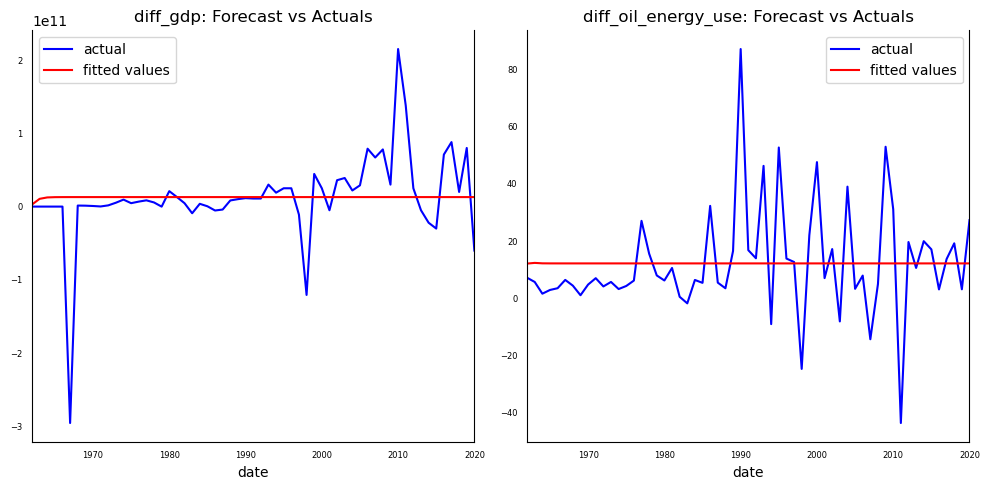

In [36]:
# Create subplots
fig, axes = plt.subplots(nrows=int(len(col_to_use)/2), 
                         ncols=2,
                         figsize=(10,5))

# Plot actual and forecasted values for each variable
for i, (col,ax) in enumerate(zip(col_to_use, axes.flatten())):
    con[col].plot(legend=True, 
                           ax=ax, 
                           color = "blue", 
                           label = "actual")
    df_forecast[col].plot(legend=True, 
                          ax=ax, 
                          color = "red", 
                          label = "fitted values").autoscale(axis='x',
                                                  tight=True);
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

# Adjust layout and show the plot
plt.tight_layout();
plt.show()

In [37]:
# Calculate and display RMSE for VAR
rmse_var = np.sqrt(mse(con["diff_oil_energy_use"], df_forecast["diff_oil_energy_use"]))
print(f'RMSE for VAR Model: {rmse_var}')

RMSE for VAR Model: 19.074990109883725


### Compare All RMSE

In [38]:
# Create the summary_rmse DataFrame
summary_rmse = pd.DataFrame({"RMSE": [rmse_naive, rmse_arima, rmse_best_arima, rmse_var]}, 
                            index=["Naive", "ARIMA", "BEST ARIMA", "VAR"])

# Display the summary_rmse DataFrame
summary_rmse

,RMSE
Naive,38.968323
ARIMA,38.663728
BEST ARIMA,40.427712
VAR,19.074990


- VAR Model Excellence: The VAR model exhibits the highest forecasting precision among the models, with an impressively low RMSE of 19.07.

- ARIMA Competence: The standard ARIMA model performs slightly better than the Best ARIMA model, showcasing its robust forecasting capabilities with an RMSE of 38.66 compared to 40.43.

- Baseline with Naive Forecast: The Naive model performs comparatively less accurately than both the VAR and ARIMA models, serving as a baseline reference with an RMSE of 38.97.